# Image Segmentation 
### Author: Sanjay Jaras
### Bellevue University

## Import Libraries

In [1]:
#!pip install git+https://github.com/tensorflow/examples.git
import os
import tensorflow as tf 
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers.experimental import preprocessing 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm
import random

## Load image file paths

In [2]:
#voc_path = "../input/pascal-voc-2012/VOC2012/"
voc_path = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/"
train_text_file = os.path.join(voc_path, "ImageSets/Segmentation/train.txt")
val_text_file = os.path.join(voc_path, "ImageSets/Segmentation/val.txt")
image_folder = os.path.join(voc_path, "JPEGImages")
mask_folder = os.path.join(voc_path, "SegmentationClass")

In [3]:
def read_paths_img_masks(text_file_path, image_path, mask_path):
    paths = []
    with open(text_file_path, "r") as file:
        file_names = file.readlines()
    for file_name in tqdm(file_names):
        image = os.path.join(image_path, file_name.strip() + ".jpg")
        mask = os.path.join(mask_path, file_name.strip() + ".png")
        paths.append((image, mask))
    return paths


## Split files into Train, Test and Validation dataset

In [4]:

train_paths = read_paths_img_masks(train_text_file, image_folder, mask_folder)
val_paths = read_paths_img_masks(val_text_file, image_folder, mask_folder)

# Adding 1000 paths from validation dataset to training dataset increase training dataset size
train_paths.extend(val_paths[0:700])
test_paths = val_paths[700:1000]
val_paths = val_paths[1000:]

#train_paths = tf.data.Dataset.from_tensors(train_paths)
#val_paths = tf.data.Dataset.from_tensors(val_paths)


100%|██████████| 1449/1449 [00:00<00:00, 387400.98it/s]


## Functions
* **normalize**: Normalize the image data and replace white color to last class
* **load_image_to_array**: Load image into array and resize it to 256*256 pixels
* **load_image_and_mask**: Load original image and masks

In [5]:

dim = 256
img_size = (dim, dim)
input_shape = [dim, dim, 3]

def normalize(input_image, input_mask1):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask1.copy()
    input_mask[input_mask == 255] = 21
    return input_image, input_mask


def load_image_to_array(file_path):
    with open(file_path, "rb") as f:
        img = PIL.Image.open(f) 
        img = img.resize(img_size)
        nparr = np.asarray(img)
        #print("nparr:", nparr.shape)
        return nparr

def load_image_and_mask(paths_tuple):
    input_image = load_image_to_array(paths_tuple[0])
    input_mask = load_image_to_array(paths_tuple[1])
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask


## Functions
* **augmentImage**: Augment original Image by flipping horizontally or vertically
* **augmentMask**: Augment original Mask by flipping horizontally or vertically
* **load_dataset**: Load all datasets

In [6]:
def augmentImage(img, left_right=True):
    aug_img = tf.image.flip_left_right(img)
    if left_right is True:
        aug_img = tf.image.flip_left_right(img)
    else:
        aug_img = tf.image.flip_up_down(img)
    return aug_img

def augmentMask(mask, left_right=True):
    mask = mask[..., np.newaxis]
    if left_right is True:
        aug_mask = tf.image.flip_left_right(mask)
    else:
        aug_mask = tf.image.flip_up_down(mask)
    aug_mask = aug_mask[:, :, 0]
    mask = mask[:, :, 0]
    return aug_mask


def load_dataset(paths, augment=False):
    imgs = []
    masks = []
    for path in tqdm(paths):
        #print("Processing: ", path)
        img, mask = load_image_and_mask(path)
        imgs.append(img)
        masks.append(mask)
        if augment is True:
            imgs.append(augmentImage(img))
            masks.append(augmentMask(mask))
            imgs.append(augmentImage(img, False))
            masks.append(augmentMask(mask, False))
            

        # break

    return np.array(imgs), np.array(masks)


## Load images into lists

In [7]:
print("Loading Training Dataset...")
train_images, train_masks = load_dataset(train_paths)
print("Loading Validation Dataset...")
val_images, val_masks = load_dataset(val_paths)
print("Loading Test Dataset...")
test_images, test_masks = load_dataset(test_paths)


TRAIN_LENGTH = len(train_images)
VAL_LENGTH = len(val_images)
print("Training dataset size:", len(train_images))
print("Test dataset size:", len(test_images))
print("Validation dataset size:", len(val_images))


Loading Training Dataset...


  0%|          | 0/2164 [00:00<?, ?it/s]2021-10-09 10:02:18.721419: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 10:02:18.722591: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-09 10:02:18.724149: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
100%|██████████| 2164/2164 [01:26<00:00, 25.10it/s]


Loading Validation Dataset...


100%|██████████| 449/449 [00:15<00:00, 28.45it/s]


Loading Test Dataset...


100%|██████████| 300/300 [00:11<00:00, 25.63it/s]


Training dataset size: 2164
Test dataset size: 300
Validation dataset size: 449


## Load datasets into TensorSliceDataset

In [8]:
train_images_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
del train_images, train_masks
test_images_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
del test_images, test_masks
val_images_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
del val_images, val_masks


## Define Batch size

In [9]:
BUFFER_SIZE = TRAIN_LENGTH
BATCH_SIZE = 32


## Create Batches for all 3 dataset

In [10]:
train_batches = (
    train_images_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
    #tf.data.AUTOTUNE

test_batches = test_images_ds.batch(BATCH_SIZE)
val_batches = val_images_ds.batch(BATCH_SIZE)

## Utility function to display Input image, mask and predicted mask side by side.

In [11]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


## Sample images and masks

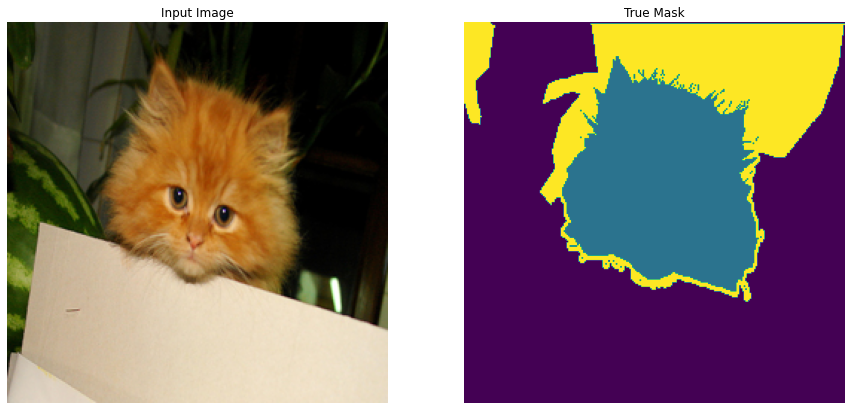

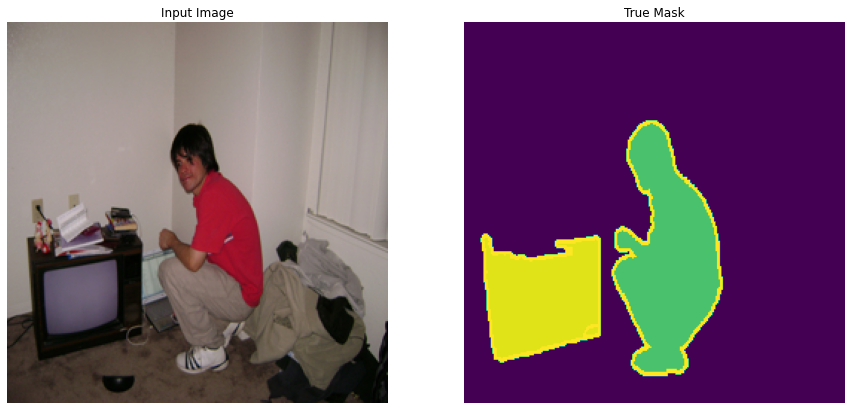

In [12]:
for images, masks in train_batches.take(2).cache():
    sample_image, sample_mask = images[0], masks[0]
    display_images([sample_image, sample_mask])

## Define Model using MobileNetV2
Use pretrained model MobileNetV2 and pick the layers for downsampling

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

## Pick the layers for upsampling

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

## Combine above steps to create UNET model

In [15]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=input_shape)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      activation="sigmoid",
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Compile unet model

In [16]:
OUTPUT_CLASSES = 22

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Functions to create mask and show predictions alongside true mask and image

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display_images([image[0], mask[0], create_mask(pred_mask)])
  else:
    display_images([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## Predictions before training the model

2021-10-09 10:04:15.536513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-09 10:04:15.553605: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601565000 Hz


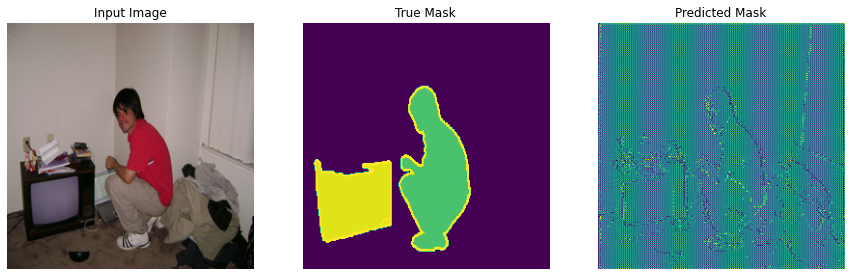

In [20]:
show_predictions()

## Callback functions for early stopping and Displaying information

In [21]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.005, restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))
        show_predictions()
        for key in logs.keys():
            print("epoch {}, the {} is {:7.2f}.".format(
             (epoch+1), key, logs[key]))
        #print(logs.keys())

## Train the model

Epoch 1/30
67/67 [==============================] - 233s 3s/step - loss: 1.8539 - accuracy: 0.5526 - val_loss: 1.7621 - val_accuracy: 0.5655

Sample Prediction after epoch 1



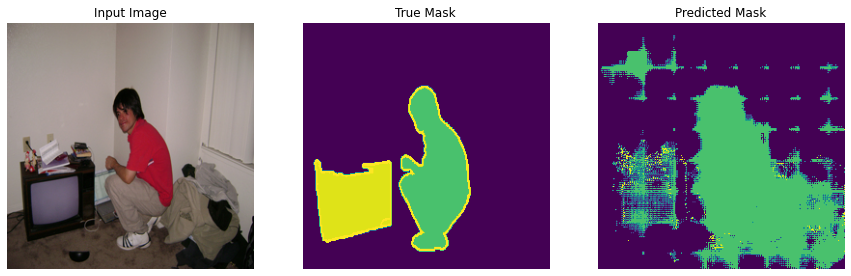

epoch 1, the loss is    1.38.
epoch 1, the accuracy is    0.67.
epoch 1, the val_loss is    1.76.
epoch 1, the val_accuracy is    0.57.
Epoch 2/30
67/67 [==============================] - 227s 3s/step - loss: 1.0326 - accuracy: 0.7344 - val_loss: 1.1673 - val_accuracy: 0.6846

Sample Prediction after epoch 2



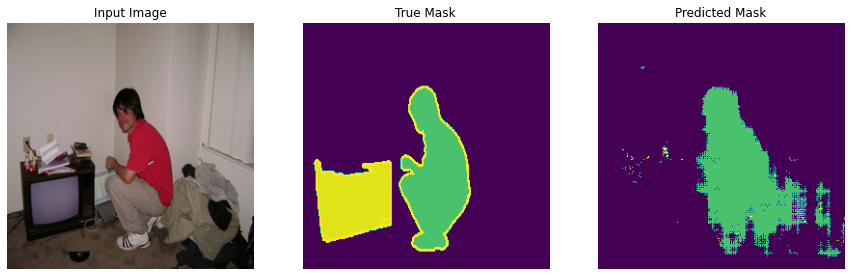

epoch 2, the loss is    0.96.
epoch 2, the accuracy is    0.75.
epoch 2, the val_loss is    1.17.
epoch 2, the val_accuracy is    0.68.
Epoch 3/30
67/67 [==============================] - 226s 3s/step - loss: 0.8462 - accuracy: 0.7616 - val_loss: 0.9687 - val_accuracy: 0.7142

Sample Prediction after epoch 3



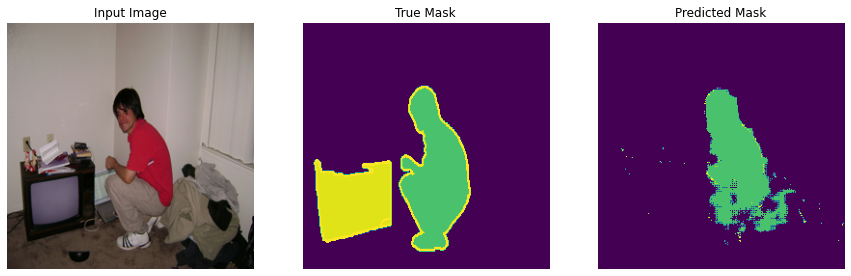

epoch 3, the loss is    0.85.
epoch 3, the accuracy is    0.76.
epoch 3, the val_loss is    0.97.
epoch 3, the val_accuracy is    0.71.
Epoch 4/30
67/67 [==============================] - 223s 3s/step - loss: 0.7707 - accuracy: 0.7704 - val_loss: 0.8570 - val_accuracy: 0.7360

Sample Prediction after epoch 4



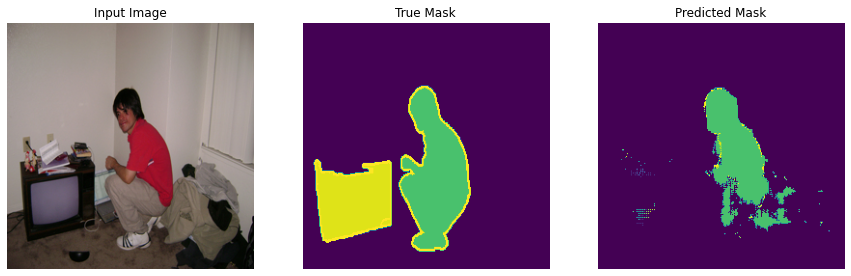

epoch 4, the loss is    0.75.
epoch 4, the accuracy is    0.77.
epoch 4, the val_loss is    0.86.
epoch 4, the val_accuracy is    0.74.
Epoch 5/30
67/67 [==============================] - 212s 3s/step - loss: 0.7193 - accuracy: 0.7839 - val_loss: 0.8472 - val_accuracy: 0.7419

Sample Prediction after epoch 5



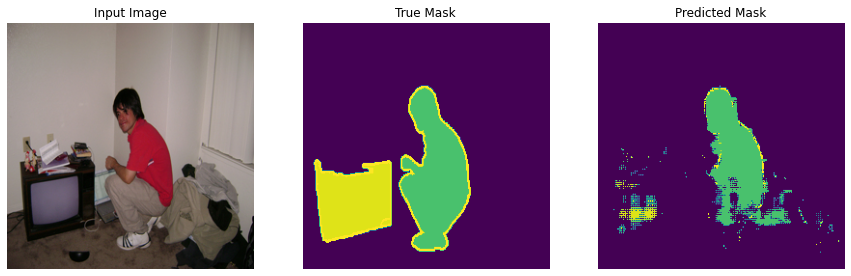

epoch 5, the loss is    0.71.
epoch 5, the accuracy is    0.79.
epoch 5, the val_loss is    0.85.
epoch 5, the val_accuracy is    0.74.
Epoch 6/30
67/67 [==============================] - 213s 3s/step - loss: 0.6462 - accuracy: 0.8048 - val_loss: 0.8445 - val_accuracy: 0.7537

Sample Prediction after epoch 6



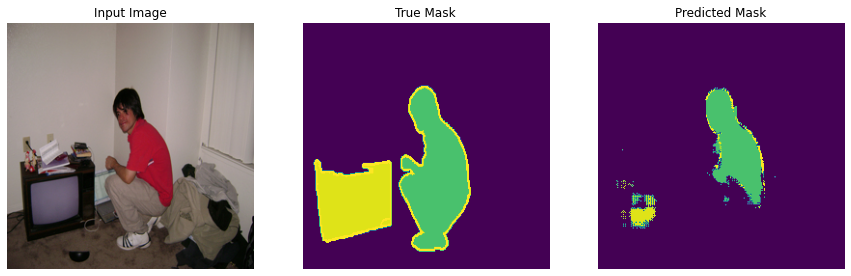

epoch 6, the loss is    0.64.
epoch 6, the accuracy is    0.81.
epoch 6, the val_loss is    0.84.
epoch 6, the val_accuracy is    0.75.
Epoch 7/30
67/67 [==============================] - 214s 3s/step - loss: 0.6184 - accuracy: 0.8171 - val_loss: 0.7155 - val_accuracy: 0.7786

Sample Prediction after epoch 7



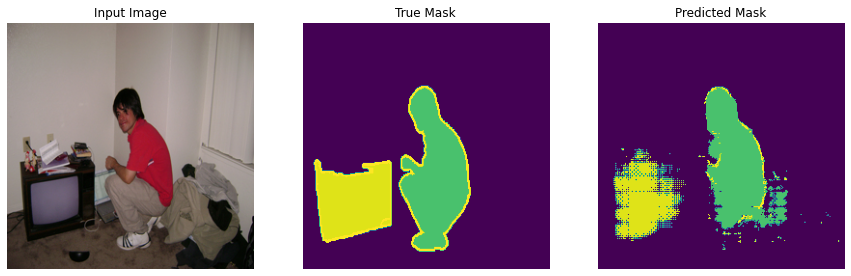

epoch 7, the loss is    0.61.
epoch 7, the accuracy is    0.82.
epoch 7, the val_loss is    0.72.
epoch 7, the val_accuracy is    0.78.
Epoch 8/30
67/67 [==============================] - 213s 3s/step - loss: 0.5545 - accuracy: 0.8343 - val_loss: 0.7393 - val_accuracy: 0.7731

Sample Prediction after epoch 8



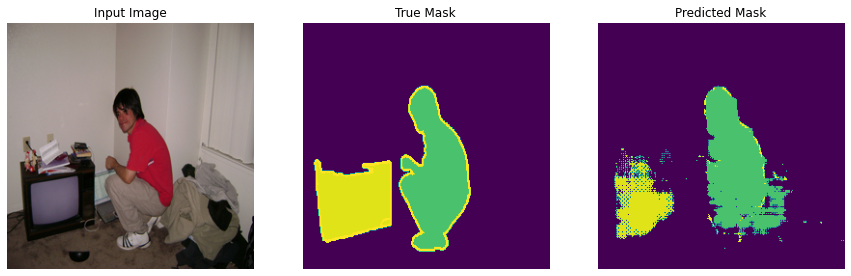

epoch 8, the loss is    0.56.
epoch 8, the accuracy is    0.83.
epoch 8, the val_loss is    0.74.
epoch 8, the val_accuracy is    0.77.
Epoch 9/30
67/67 [==============================] - 227s 3s/step - loss: 0.5333 - accuracy: 0.8382 - val_loss: 0.6581 - val_accuracy: 0.7994

Sample Prediction after epoch 9



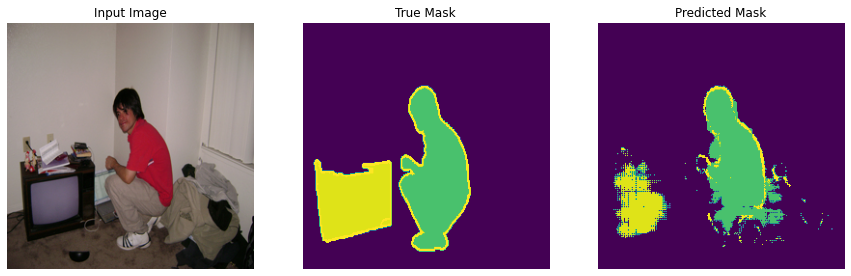

epoch 9, the loss is    0.54.
epoch 9, the accuracy is    0.84.
epoch 9, the val_loss is    0.66.
epoch 9, the val_accuracy is    0.80.
Epoch 10/30
67/67 [==============================] - 231s 3s/step - loss: 0.5328 - accuracy: 0.8357 - val_loss: 0.6669 - val_accuracy: 0.8021

Sample Prediction after epoch 10



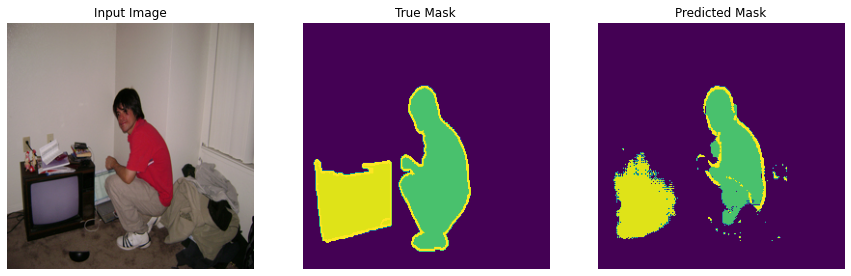

epoch 10, the loss is    0.52.
epoch 10, the accuracy is    0.84.
epoch 10, the val_loss is    0.67.
epoch 10, the val_accuracy is    0.80.
Epoch 11/30
67/67 [==============================] - 228s 3s/step - loss: 0.5056 - accuracy: 0.8448 - val_loss: 0.6405 - val_accuracy: 0.8061

Sample Prediction after epoch 11



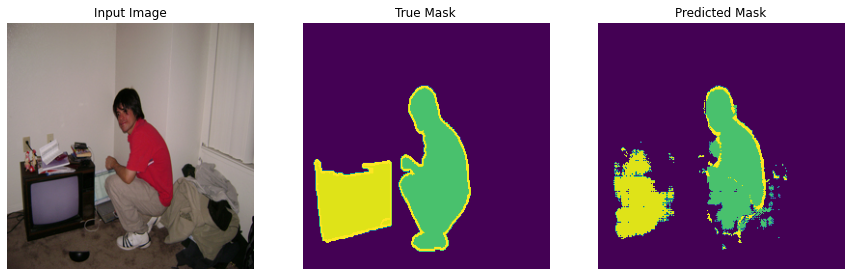

epoch 11, the loss is    0.50.
epoch 11, the accuracy is    0.85.
epoch 11, the val_loss is    0.64.
epoch 11, the val_accuracy is    0.81.
Epoch 12/30
67/67 [==============================] - 224s 3s/step - loss: 0.4748 - accuracy: 0.8532 - val_loss: 0.6490 - val_accuracy: 0.8102

Sample Prediction after epoch 12



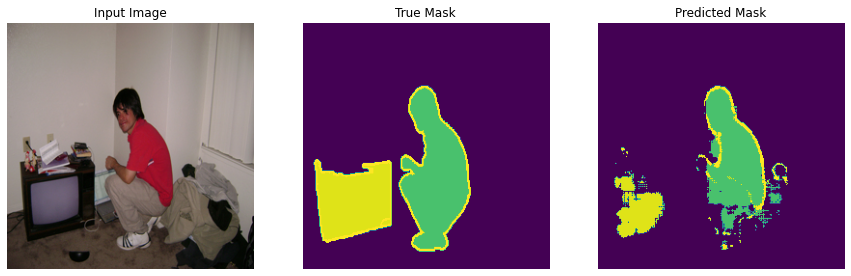

epoch 12, the loss is    0.48.
epoch 12, the accuracy is    0.85.
epoch 12, the val_loss is    0.65.
epoch 12, the val_accuracy is    0.81.
Epoch 13/30
67/67 [==============================] - 220s 3s/step - loss: 0.4713 - accuracy: 0.8517 - val_loss: 0.6680 - val_accuracy: 0.8003

Sample Prediction after epoch 13



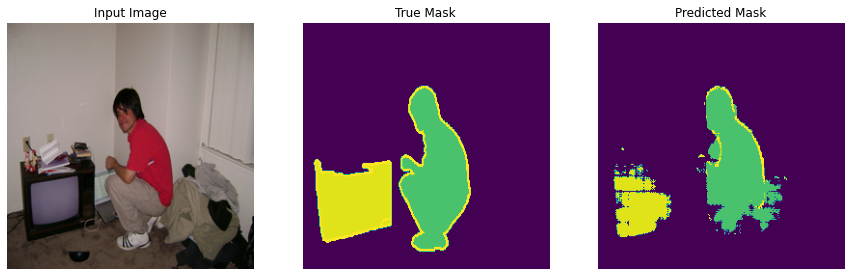

epoch 13, the loss is    0.47.
epoch 13, the accuracy is    0.85.
epoch 13, the val_loss is    0.67.
epoch 13, the val_accuracy is    0.80.
Epoch 14/30
67/67 [==============================] - 238s 4s/step - loss: 0.4614 - accuracy: 0.8563 - val_loss: 0.6634 - val_accuracy: 0.7993

Sample Prediction after epoch 14



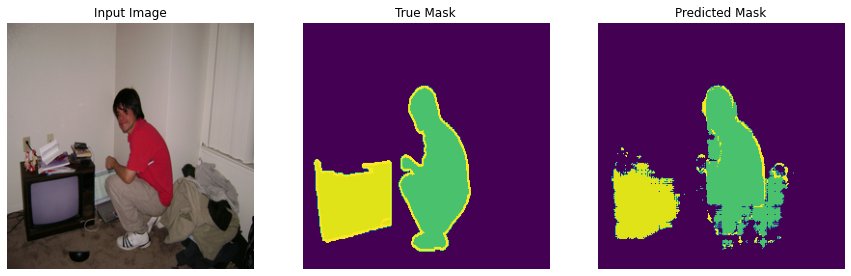

epoch 14, the loss is    0.46.
epoch 14, the accuracy is    0.86.
epoch 14, the val_loss is    0.66.
epoch 14, the val_accuracy is    0.80.


In [22]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS #10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback(), earlyStopCallback])

## Plot accuracy and loss for training and validations

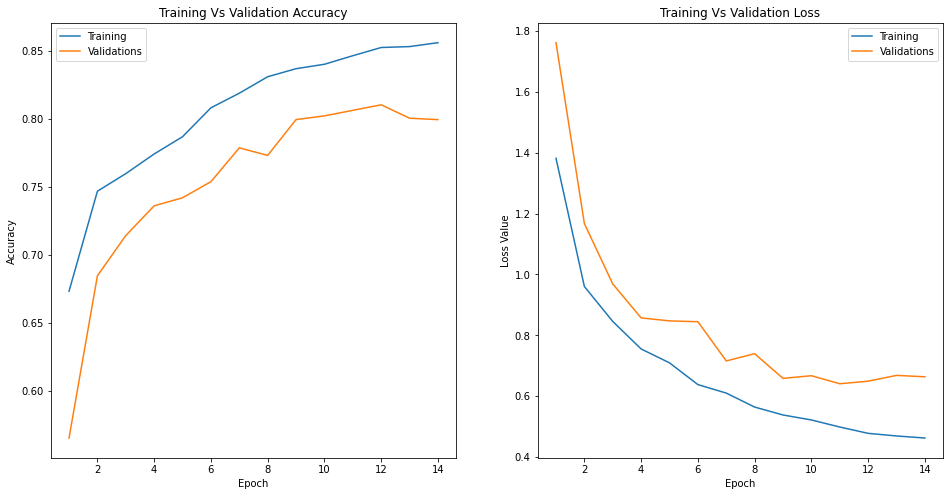

In [23]:
length = len(model_history.history["accuracy"])+1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
titles = ['Training Vs Validation Accuracy', 'Training Vs Validation Loss']
ax[0].set_title(titles[0])
ax[0].plot(range(1, length), model_history.history["accuracy"])
ax[0].plot(range(1, length), model_history.history["val_accuracy"])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(["Training", "Validations"])


ax[1].set_title(titles[1])
ax[1].plot(range(1, length), model_history.history["loss"])
ax[1].plot(range(1, length), model_history.history["val_loss"])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend(["Training", "Validations"])
plt.show()

## Evalute model against test dataset

In [24]:
model.evaluate(test_batches)

10/10 [==============================] - 10s 1s/step - loss: 0.5272 - accuracy: 0.8452


[0.5272488594055176, 0.8451809287071228]

## Sample predictions from validation dataset

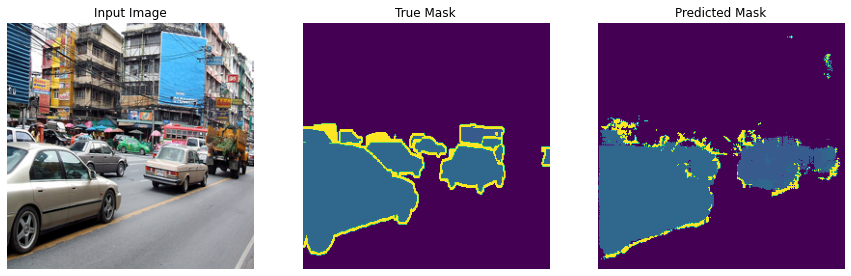

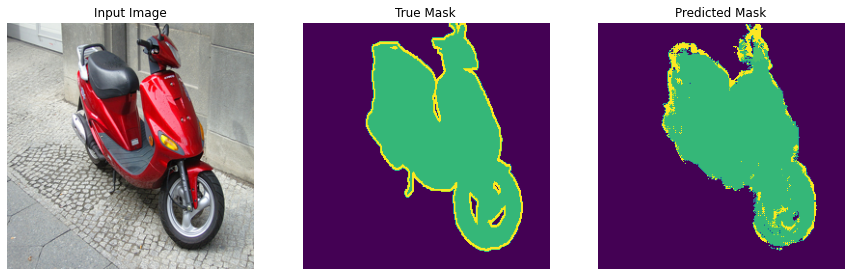

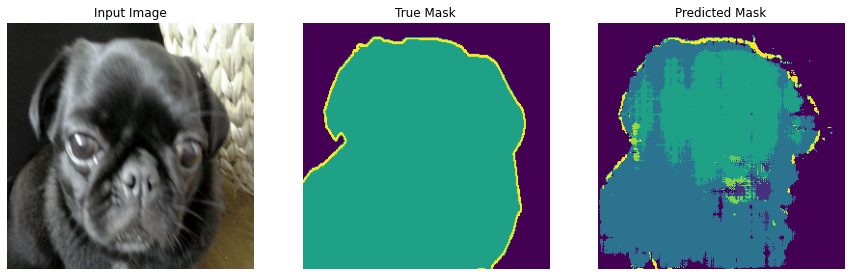

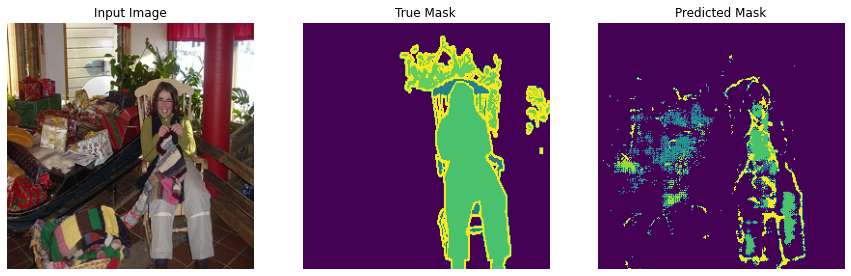

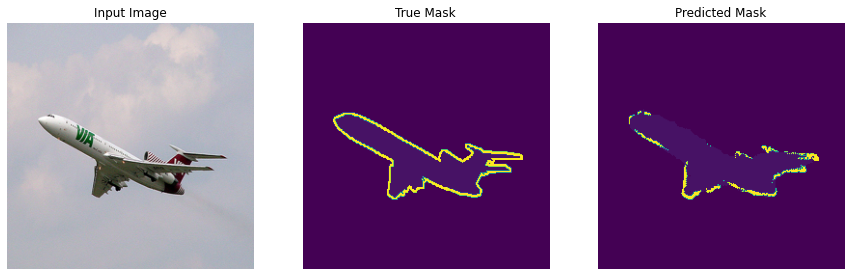

In [25]:
show_predictions(val_batches.shuffle(buffer_size=64), num =5)

## Extract Images from original image using predicted mask from Test dataset

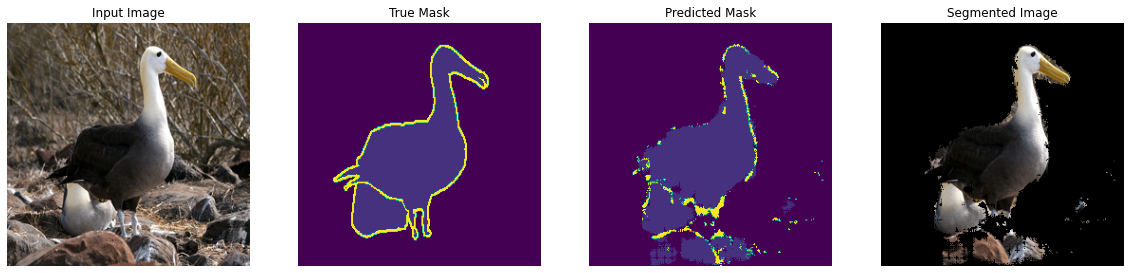

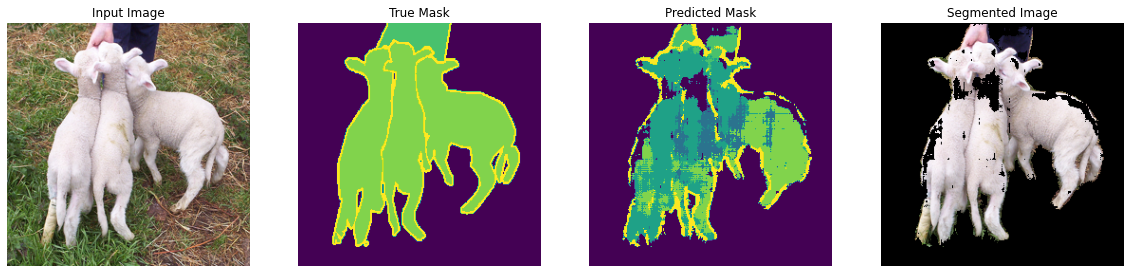

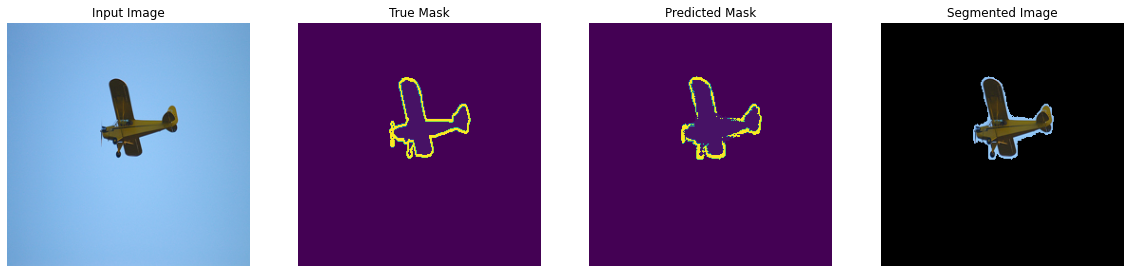

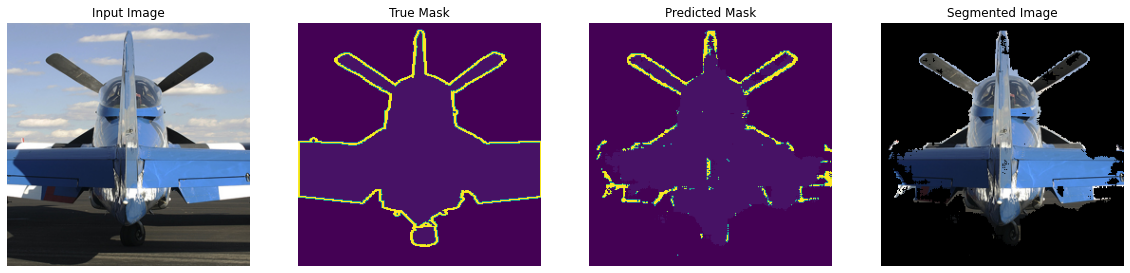

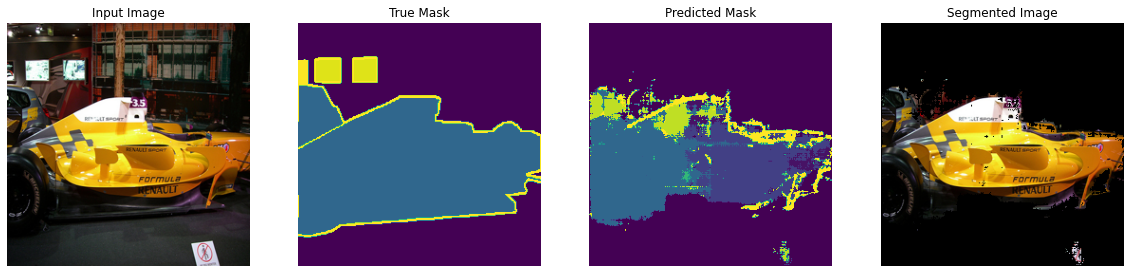

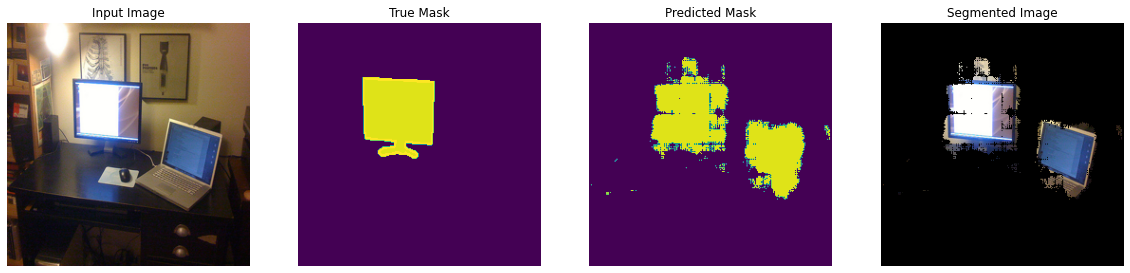

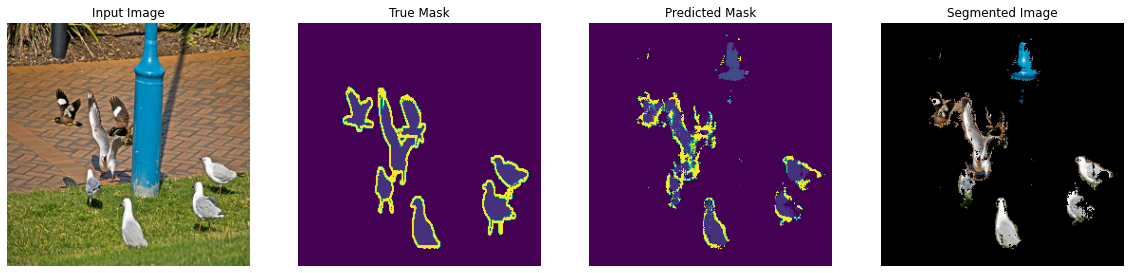

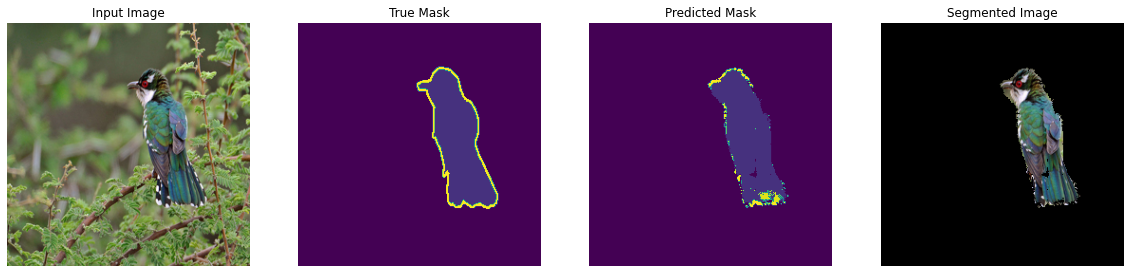

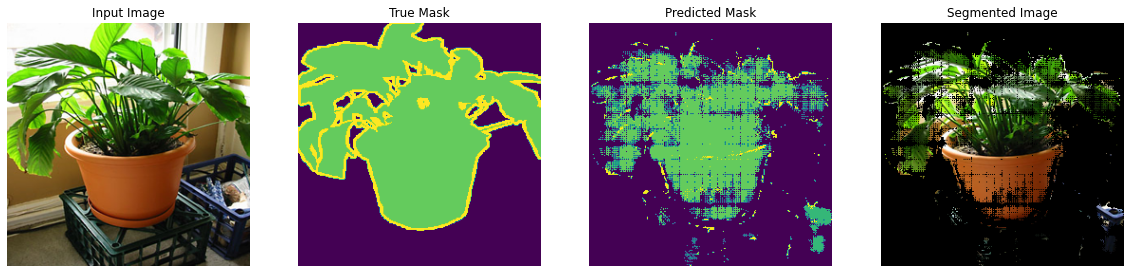

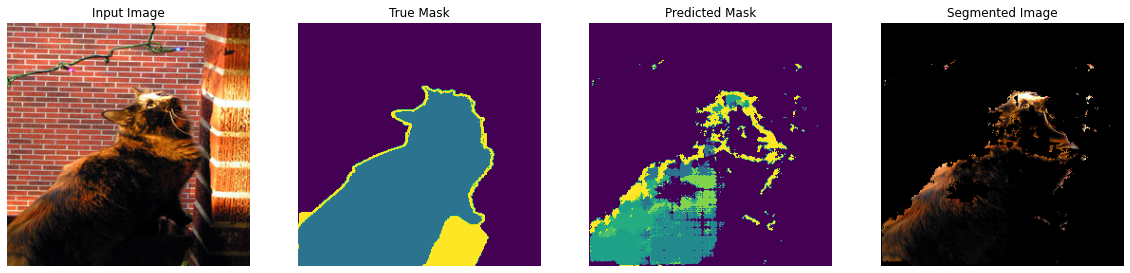

In [26]:
def display_results(display_list):
  plt.figure(figsize=(20, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Segmented Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

cnt = 0
for image, mask in test_batches.take(10):
    pred_mask_1 = model.predict(image)
    pred_mask_1 = create_mask(pred_mask_1)
    pred_mask = (np.array(pred_mask_1) !=0).astype(int)
    display_results([image[0], mask[0], pred_mask_1[:, :, 0], image[0] * pred_mask])
    cnt += 1